<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>Nonnegative Matrix Factorization (NMF)</h1> 
</div>

<br/>

<p>
Following Section 8.3.1 <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we cover in this notebook a technique known as nonnegative matrix factorization (NMF). The formal definition of the NMF problem and an iterative learning procedure for computing a factorization in practice was first described by Lee and Seoung. Implementations and applications for NMF can also be found in the <a href="https://www.audiolabs-erlangen.de/resources/MIR/NMFtoolbox/"><strong>NMF Toolbox</strong>.</a>    

<ul>
<li><span style="color:black">
Daniel D. Lee, H. Sebastian Seung: <a href="https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf"><strong>Algorithms for Non-negative Matrix Factorization.</strong></a> Proceedings of the Neural Information Processing Systems (NIPS), Denver, CO, USA, pp. 556&ndash;562, 2000.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_LeeS00_AlgorithmsNmf_NIPS.txt"> Bibtex </a>
</span></li>
<li><span style="color:black">
Patricio López-Serrano, Christian Dittmar, Yigitcan Özer, and Meinard Müller: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2019_LopezSerranoDOM_NMF_DAFx.pdf"><strong>NMF Toolbox: Music processing applications of nonnegative matrix factorization.</strong></a>Proceedings of the International Conference on Digital Audio Effects (DAFx), Birmingham, UK, 2019.
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_LopezDOM19_ToolboxNMF_DAFx.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="https://www.audiolabs-erlangen.de/resources/MIR/NMFtoolbox/">MATLAB and Python Toolbox</a>
</span></li>
</ul>   
</p> 

## Basic Idea

**Nonnegative matrix factorization** (NMF) is a technique where a matrix $V$ with nonnegative entries is factored into two matrices $W$ and $H$ that also have only nonnegative entries:

<img src="../data/C8/FMP_C8_F20b.png" width="400px" align="middle" alt="FMP_C8_F20b">

Typically, the matrices $W$ and $H$ are required to have a much lower rank than the original matrix $V$. This factorization is interpreted as follows: The columns of $V$ are regarded as data vectors. The underlying assumption is that these vectors can be represented as a weighted superposition of a relatively small number of **template** vectors. The columns of $W$ correspond to these templates. Furthermore, the rows of $H$&mdash;called **activations**&mdash;indicate where these templates occur in $V$. The nonnegativity constraints often lead to a decomposition that allows for a semantically meaningful interpretation of the coefficients. However, in most cases, the resulting factorization problem has no exact solution, thus requiring optimization procedures for finding suitable numerical approximations. In the following, to build up some intuition, we give a factorization example form the music domain. Subsequently, we formally introduce the NMF problem and discuss an iterative learning procedure. 

## Example: Spectrogam Factorization 

As illustration of NMF, we show how this technique can be used to factorize a spectrogram of a music recording into musically meaningful components. Let us consider the first measures of the Prélude Op. 28, No. 4 by Frédéric Chopin. The following figure shows the musical score as well as a piano-roll representation of the score synchronized to an audio recording of a performance. For illustration purposes, all information related to the note number $p=71$ is highlighted by the red rectangular frames.

<img src="../data/C8/FMP_C8_F21a-b.png" width="600px" align="left" alt="FMP_C8_F21a-b">

<br clear="all" />

<audio style="width: 320px;" src="../data/C8/FMP_C8_F27_Chopin_Op028-04_minor.mp3" type="audio/mpeg" controls="controls"></audio>

As for the original data matrix $V$, we use the [magnitude STFT](../C2/C2_STFT-Basic.html), which is a sequence of spectral vectors. Using NMF, this matrix can be factorized into a product of two nonnegative matrices $W$ and $H$. In the ideal case, the first matrix $W$ represents the spectral patterns of the notes' pitches that occur in the piece of music, while the second matrix $H$ exhibits the time positions where these spectral patterns are active in the audio recording. The following figure shows such a factorization for our Chopin example.

<img src="../data/C8/FMP_C8_F21c-e.png" width="700px" align="middle" alt="FMP_C8_F21c-e">

In this case, each template specified by the matrix $W$ reflects how a note of a certain pitch is spectrally realized in $V$, and the activation matrix $H$ looks similar to the piano-roll representation of the score. In practice, however, it is often hard to predict which of the signal's properties are ultimately captured by the learned factors. 
To better control this factorization, we will show how additional score information can be used to [constrain NMF](../C8/C8S3_NMFAudioDecomp.html) to yield a musically meaningful decomposition. 

## Formal Definition of NMF

A matrix with real-valued coefficients is called **nonnegative** if all the coefficients are either zero or positive. Let $V \in \mathbb{R}_{\ge 0}^{K \times N}$ be such a nonnegative matrix having $K\in\mathbb{N}$ rows and $N\in\mathbb{N}$ columns. The dimensions $K$ and $N$ of the matrix $V$ are usually thought to be large. Given a number $R\in\mathbb{N}$ smaller than both $K$ and $N$, the goal of NMF is to find two nonnegative matrices $W \in \mathbb{R}_{\ge 0}^{K \times R}$ and $H \in \mathbb{R}_{\ge 0}^{R \times N}$ such that 

\begin{equation}
    V \approx W \cdot H.
\end{equation}

As said above, the columns of $V$ are regarded as $K$-dimensional data vectors, where $N$ is the number of data vectors. This matrix is then approximately factorized into a $(K \times R)$ matrix $W$ and an $(R \times N)$ matrix $H$. The parameter $R$, which is referred to as the **rank** of the factorization, is usually chosen to be much smaller than $K$ and $N$. Therefore, the number of coefficients in $W$ and $H$ is typically much smaller than the total number in $V$ (i.e., $KR+RN \ll KN$), and the product $WH$ can be thought of as a compressed version of the original matrix $V$. As already mentioned before, the column vectors of $W$ are also referred to as **template vectors**, whereas the weights specified by $H$ are called **activations**. As opposed to arbitrary linear combinations as known from linear algebra, the linear combinations occurring in the NMF context only involve nonnegative weights of nonnegative template vectors. As a result, there are no effects such as destructive interferences, where a (positive) component can be canceled out by adding a kind of inverse (negative) component. Instead, the data vectors need to be explained in a purely constructive fashion only involving positive components.

To find an approximate factorization $V \approx W \cdot H$, we need to specify a distance function that quantifies the 
quality of the approximation. There are many ways for defining such a distance function, leading to different NMF variants. In the following, we only consider one of these variants, which is based on the **Euclidean distance**. Let $A,B\in\mathbb{R}^{K \times N}$ be two matrices with coefficients $A_{kn}$ and $B_{kn}$
for $k\in[1:K]$ and $n\in[1:N]$. Then, the square of the Euclidean distance between $A$ and $B$ is defined by

\begin{equation}
    \|A-B\|^2:= \sum_{k=1}^{K}\sum_{n=1}^{N}(A_{kn}-B_{kn})^2.
\end{equation}

Based on this distance measure, we can formalize our NMF problem as follows: Given a nonnegative matrix $V\in\mathbb{R}_{\ge 0}^{K \times N}$ and a rank parameter $R$, minimize

\begin{equation}
    \|V-WH\|^2
\end{equation}

with respect to $W \in \mathbb{R}_{\ge 0}^{K \times R}$  and $H \in \mathbb{R}_{\ge 0}^{R \times N}$. In other words, regarding $\|V-WH\|^2$ as a joint function of $W$ and $H$, the objective is to find a minimum under the nonnegativity constraint for $W$ and $H$. For general matrices, this is a hard computational problem due to several reasons. First, it is in general difficult to enforce hard constraints such as nonnegativity on the solution of an optimization problem. Second, the joint optimization over both matrices $W$ and $H$ leads to computational challenges. In fact, when regarding $\|V-WH\|^2$ as a function of $W$ only or $H$ only, one can show that the resulting functions satisfy a strong property referred to as **convexity**. This property, which implies that any local minimum must be a global minimum, makes it possible to apply powerful tools from the field of convex analysis.  However, $\|V-WH\|^2$ is **not convex** in both matrices together. Therefore, it is unrealistic to expect an algorithm that can solve this problem in the sense of finding a global minimum. However, there are many techniques from numerical optimization that can be applied to find local minima.

## Multiplicative Update Rules

<a href="https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf">Lee and Seung</a> introduced in their seminal paper a powerful algorithm based on multiplicative update rules to iteratively learn a nonnegative matrix factorization. In the following, we only summarize their algorithm and refer to their paper or Section 8.3.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> for a proof. The idea is based on the standard gradient descent approach, which is applied to our problem of minimizing $\|V-WH\|^2$ as a function of $W$ and $H$. Since the joint optimization is a very hard problem, one idea is to first fix the factor $W$ and to optimize with regard to $H$, and then to fix the learned factor $H$ and to optimize with regard to $W$. This process is then iterated, where the role of $W$ and $H$ is interchanged after each step. In standard gradient descent the update rules are additive, where a parameter needs to be chosen to control the **step size** towards the direction of the negative gradient. The main trick in the NMF optimization algorithm is that this step size parameter can be set in a specific way so that the **additive** update rules become **multiplicative** update rules. The following table shows the iterative algorithm for learning an NMF decomposition., where the multiplicative update rules are given in matrix notation. The operator $\odot$ denotes pointwise multiplication and the operator $\oslash$ pointwise division. 

<img src="../data/C8/FMP_C8_T01.png" width="600px" align="middle" alt="FMP_C8_T01">

The multiplicative update rules and their properties have a number of remarkable implications.

* The first implication is that the matrix sequences $W^{(0)},W^{(1)},W^{(2)},\ldots$ and $H^{(0)},H^{(1)},H^{(2)},\ldots$ converge. Denoting the limit matrices by $W^{(\infty)}$ and $H^{(\infty)}$, the stationarity property implies that these matrices form a local minimum of the distance function $\|V-WH\|^2$.
* Second, the multiplicative update rules are extremely easy to implement. 
* Third, in practice, the convergence turns out to be relatively fast in comparison with many other methods.
* Fourth, one major benefit of using multiplicative update rules is that the nonnegativity constraints are enforced automatically.

Indeed, starting with nonnegative matrices $V$, $W^{(0)}$, and $H^{(0)}$, all entries in the equations (1) and (2) of the above table are also nonnegative. Since all operations are multiplicative (either multiplication or division), also the matrices $W^{(\ell)}$ and $H^{(\ell)}$ remain nonnegative throughout the iteration.

In practice, the iteration is performed until a specified stop criterion is fulfilled. For example, one may perform a certain number of iterations $\ell=0,1,2,\ldots, L$ for some user-specified parameter $L\in\mathbb{N}$. As another stop criterion, one may look at the distances between two subsequently computed template matrices and activation matrices. Specifying a threshold $\varepsilon>0$, the iteration may be stopped when $\|H^{(\ell+1)}-H^{(\ell)}\|^2\leq \varepsilon$ and $\|W^{(\ell+1)}-W^{(\ell)}\|^2\leq \varepsilon$. Note that this stop criterion does not say anything about the quality of the approximation $V\approx WH$ achieved by the procedure. Even in the limit case and even when converging to the global minimum (and not to a local one), the distance $\|V-WH\|^2$ may still be large. In particular, this may happen if the rank parameter $R$ is chosen too small.

## Implementation

In the following code cell, we provide a basic implementation that closely follows the NMF procedure described above. Here are some important notes:

* All operation are performed using matrix-based operations.
* To avoid devision by zero, a small value (machine epsilon) is added to the denominators in the multiplicative update rules.
* In the factorization $V\approx WH$, there is a degree of freedom with regard to columns and rows of $W$ and $H$, respectively. For example, one may divide a column of $W$ by a factor $\alpha\in\mathbb{R}$ and multiply the correspond row of $H$ by the same factor without changing the product $WH$. In the following code, setting the parameter `norm=True`, we use this fact to enforce that all columns of the final template matrix $W$ are normalized with regard to the [maximum norm](../C3/C3S1_FeatureNormalization.html).
* If not specified, the matrices $W$ and $H$ are initialized randomly. The power of NMF lies in the possibility of guiding the decomposition process by [initializing the matrices in a musically informed way](../C8/C8S3_NMFAudioDecomp.html).

In [1]:
import os, sys
import numpy as np
import scipy
#import scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
#from matplotlib import gridspec
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

@jit(nopython=True)
def nmf(V, R, thresh=0.001, L=1000, W=None, H=None, norm=False, report=False):
    """NMF algorithm with Euclidean distance

    Notebook: C8/C8S3_NMFbasic.ipynb

    Args:
        V: Nonnegative matrix of size K x N
        R: Rank parameter
        thresh: Threshold used as stop criterion
        L: Maximal number of iteration
        W: Nonnegative matrix of size K x R used for initialization
        H: Nonnegative matrix of size R x N used for initialization
        norm (bool): Applies max-normalization of columns of final W
        report (bool): Reports errors during runtime

    Returns:
        W: Nonnegative matrix of size K x R
        H: Nonnegative matrix of size R x N
        V_approx: Nonnegative matrix W*H of size K x N
        V_approx_err: Error between V and V_approx
        H_W_error: History of errors of subsequent H and W matrices
    """
    K = V.shape[0]
    N = V.shape[1]
    if W is None:
        W = np.random.rand(K, R)
    if H is None:
        H = np.random.rand(R, N)
    V = V.astype(np.float64)
    W = W.astype(np.float64)
    H = H.astype(np.float64)
    H_W_error = np.zeros((2, L))
    ell = 1
    below_thresh = False
    eps_machine = np.finfo(np.float32).eps
    while not below_thresh and ell <= L:
        H_ell = H
        W_ell = W
        H = H * (W.transpose().dot(V) / (W.transpose().dot(W).dot(H) + eps_machine))
        W = W * (V.dot(H.transpose()) / (W.dot(H).dot(H.transpose()) + eps_machine))

        # H+1 = H *p ((W^T * V) / p (W^T * W * H))
        # H = np.multiply(H, np.divide(np.matmul(np.transpose(W), V),
        #                              np.matmul(np.matmul(np.transpose(W), W), H)))
        # W+1 = W *p ((V * H^T) / p (W * H * H^T))
        # W = np.multiply(W, np.divide(np.matmul(V, np.transpose(H)),
        #                              np.matmul(np.matmul(W, H), np.transpose(H))))

        H_error = np.linalg.norm(H-H_ell, ord=2)
        W_error = np.linalg.norm(W - W_ell, ord=2)
        H_W_error[:, ell-1] = [H_error, W_error]
        if report:
            print('Iteration: ', ell, ', H_error: ', H_error, ', W_error: ', W_error)
        if H_error < thresh and W_error < thresh:
            below_thresh = True
            H_W_error = H_W_error[:, 0:ell]
        ell += 1
    if norm:
        for r in range(R):
            v_max = np.max(W[:, r])
            if v_max > 0:
                W[:, r] = W[:, r] / v_max
                H[r, :] = H[r, :] * v_max
    V_approx = W.dot(H)
    V_approx_err = np.linalg.norm(V-V_approx, ord=2)
    return W, H, V_approx, V_approx_err, H_W_error  

## Toy Example

We illustrate the functioning of the NMF procedure by means of a small toy example $V \in \mathbb{R}_{\ge 0}^{K \times N}$ with $K=4$ and $N=8$. The rank parameter is set to $R=2$.

Matrix V and randomly initialized matrices W and H


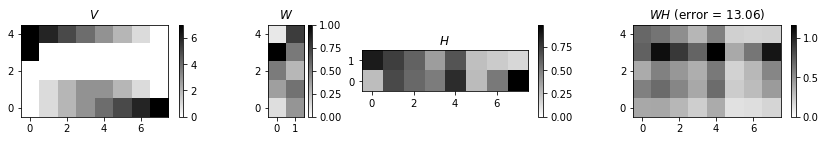

Matrix V and matrices W and H after training


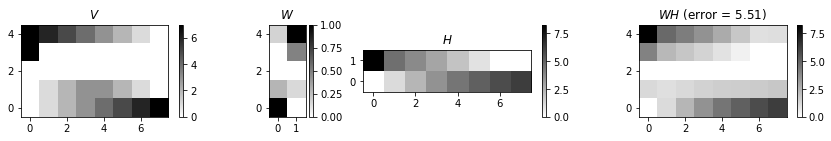

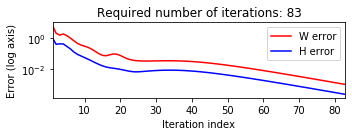

In [2]:
 def plot_nmf(V, W, H, V_approx, error, figsize=(10,2), aspect='auto', wr=[1, 0.5, 1, 1]): 
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': wr},
                           figsize=figsize)    
    cmap = 'gray_r'
    im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V)])
    ax[0].set_title(r'$V$')
    plt.sca(ax[0])
    plt.colorbar(im)   
    im = ax[1].imshow(W, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(W)])
    ax[1].set_title(r'$W$')
    plt.sca(ax[1])
    plt.colorbar(im)
    im = ax[2].imshow(H, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(H)])
    ax[2].set_title(r'$H$')
    plt.sca(ax[2])    
    plt.colorbar(im)
    im = ax[3].imshow(V_approx, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V_approx)])
    ax[3].set_title(r'$WH$ (error = %0.2f)'%error)
    plt.sca(ax[3])    
    plt.colorbar(im)
    plt.tight_layout() 
    plt.show() 
    
V = np.array([ 
    [0, 1, 2, 3, 4, 5, 6, 7], 
    [0, 1, 2, 3, 3, 2, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0], 
    [7, 0, 0, 0, 0, 0, 0, 0], 
    [7, 6, 5, 4, 3, 2, 1, 0]    
             ],dtype=float)

K = V.shape[0]
N = V.shape[1]
R = 2
thresh = 0.001
L = 100

W_init =  np.random.rand(K,R) 
W_init = W_init/np.max(W_init)
H_init = np.random.rand(R,N)    

print('Matrix V and randomly initialized matrices W and H')
V_approx = W_init.dot(H_init)
error = np.linalg.norm(V-V_approx, ord=2)
plot_nmf(V, W_init, H_init, V_approx, error, figsize=(12,2), 
         aspect='equal', wr=[1, 0.3, 1, 1])

print('Matrix V and matrices W and H after training')
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                   L=L, W=W_init, H=H_init, norm=1, report=0)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
         aspect='equal', wr=[1, 0.3, 1, 1])

plt.figure(figsize=(5,2))
num_iter = H_W_error.shape[1]
plt.plot(np.arange(num_iter)+1, H_W_error[0,:], 'r', label='W error')
plt.plot(np.arange(num_iter)+1, H_W_error[1,:], 'b', label='H error')
plt.yscale('log')
plt.xlabel('Iteration index')
plt.ylabel('Error (log axis)')
plt.title('Required number of iterations: %d'%num_iter)
plt.xlim([1, num_iter])
plt.legend()
plt.tight_layout()

## Dependency on Rank Parameter

In the last example, the two templates (columns of $W$) learned by NMF mainly capture characteristics of the dominating (in terms of coefficient values) first and last column of $V$, respectively. The example shows that the error between $V$ and the learned product $WH$ may still be large. This may hold even in the case that the NMF algorithm converges to a global optimum. In the following example, we show different decomposition using different parameters $R$. Obviously, using $R=1$ is the most restrictive case, where only a single template vector is used to "explain" the entire matrix $V$. Increasing $R$, one obtains better approximations of $V\approx WH$. However, the matrices $W$ and $H$ are less structured and become harder to interpret.

R = 1


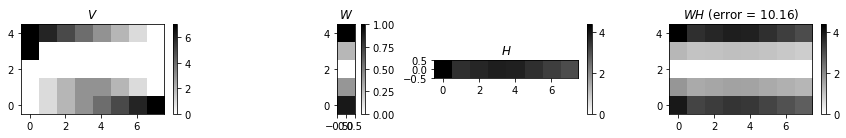

R = 2


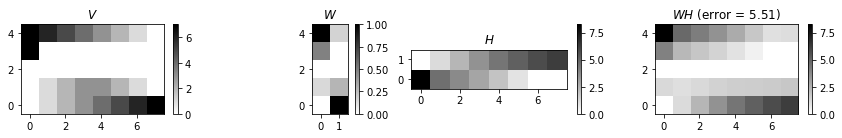

R = 3


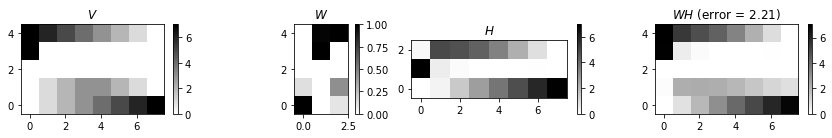

R = 4


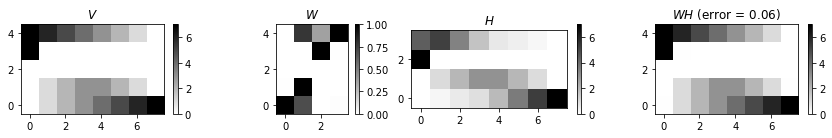

In [3]:
thresh = 0.00001
L = 100
R_set = np.array([1, 2, 3, 4])
for R in R_set: 
    print('R = %d'%R)
    W_init =  np.random.rand(K,R) 
    W_init = W_init/np.max(W_init)
    H_init = np.random.rand(R,N)    
    W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                       L=L, W=W_init, H=H_init, norm=1, report=0)
    plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
             aspect='equal', wr=[1, 0.7, 1, 1])

## Example: C-Major Scale

We close this notebook with a first music scenario, where we apply NMF to the **magnitude spectrogram** of a real audio signal. As example, we use a recording of the C-major scale played on a piano starting with $\mathrm{C4}$ ($261.6~\mathrm{Hz}$) and ending with $\mathrm{C5}$ ($523.2~\mathrm{Hz}$). 

<img src="../data/C8/FMP_C8_Audio_C-major-scale.png" width="400px" align="left" alt="C1">

<br clear="all" />

<audio src="../data/C8/FMP_C8_Audio_C-major-scale.mp3" type="audio/mpeg" controls="controls"></audio>

As input matrix $V$, we only consider the lower-frequency part of the STFT (for better visibility). In a first experiment, we use $R=7$.

Matrix V and randomly initialized matrices W and H


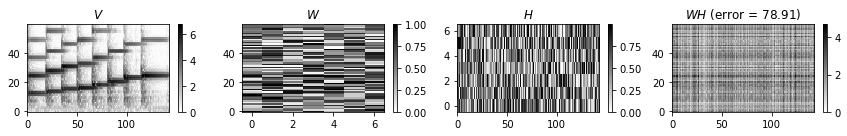

Matrix V and matrices W and H after training


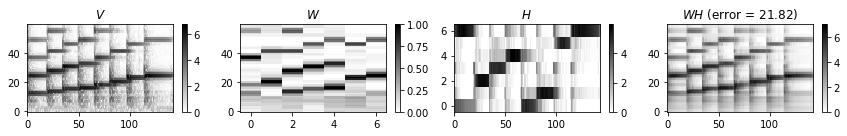

In [4]:
Fs = 22050
fn_wav = os.path.join('..', 'data', 'C3', 'FMP_C3_F08_C-major-scale.wav')

x, Fs = librosa.load(fn_wav, sr=Fs)
N, H = 1024, 512
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', center=True, pad_mode='constant')
V = np.log(1 + 10 * np.abs(X))
V = V[0:60,:]

K = V.shape[0]
N = V.shape[1]
R = 7
thresh = 0.0001
L = 200

W_init =  np.random.rand(K,R) 
W_init = W_init/np.max(W_init)
H_init = np.random.rand(R,N)    
V_approx = W_init.dot(H_init)
error = np.linalg.norm(V-V_approx, ord=2)
print('Matrix V and randomly initialized matrices W and H')
plot_nmf(V, W_init, H_init, V_approx, error, figsize=(12,2), wr=[1, 1, 1, 1])

W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                              L=L, W=W_init, H=H_init, norm=1, report=0)
print('Matrix V and matrices W and H after training')
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

The figure implies that, at least visually, one obtains a good overall approximation $V\approx WH$. The seven templates encoded by $W$ correspond to prototypical spectral vectors of the C-major scale's notes, where the first (C4) and last note (C5) share a template. This example also shows that the order of the template columns in $W$ (and the same with the activation rows of $H$) do not have any semantics. Indeed, the NMF decomposition does not favor any order. When increasing the rank parameter, one usually obtains a better overall approximation quality, as illustrated by the next figure. For examples, details such as onset-related (vertical) structures are better reconstructed compared to using a small $R$. However, as a downside, the musical interpretation of $W$ and $H$ may get lost. We will discuss in the [FMP notebook on NMF-based spectrogram factorization](../C8/C8S3_NMFSpecFac.html) how semantics may be preserved by introducing musically informed constraints.

Matrix V and matrices W and H after training using R = 4


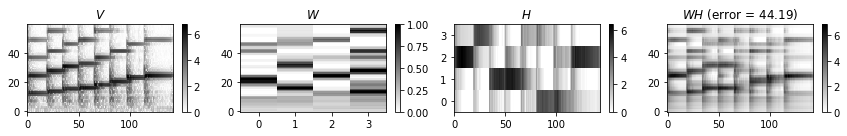

Matrix V and matrices W and H after training using R = 10


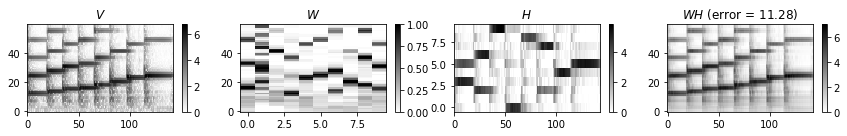

Matrix V and matrices W and H after training using R = 15


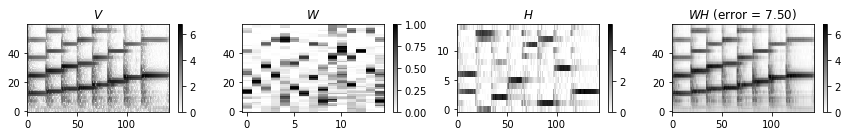

In [5]:
R = 4
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, L=L, norm=1)
print('Matrix V and matrices W and H after training using R = %d'%R)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

R = 10
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, L=L, norm=1)
print('Matrix V and matrices W and H after training using R = %d'%R)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

R = 15
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, L=L, norm=1)
print('Matrix V and matrices W and H after training using R = %d'%R)
plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), wr=[1, 1, 1, 1])

## Further Notes

* An application of NMF can be found in the [FMP notebook on NMF-based audio decomposition](../C8/C8S3_NMFAudioDecomp.html), where score information is used to guide the decomposition. 

* Further extensions, implementations, and applications of NMF can be found in the 
<a href="https://www.audiolabs-erlangen.de/resources/MIR/NMFtoolbox/"><strong>NMF Toolbox</strong>.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>